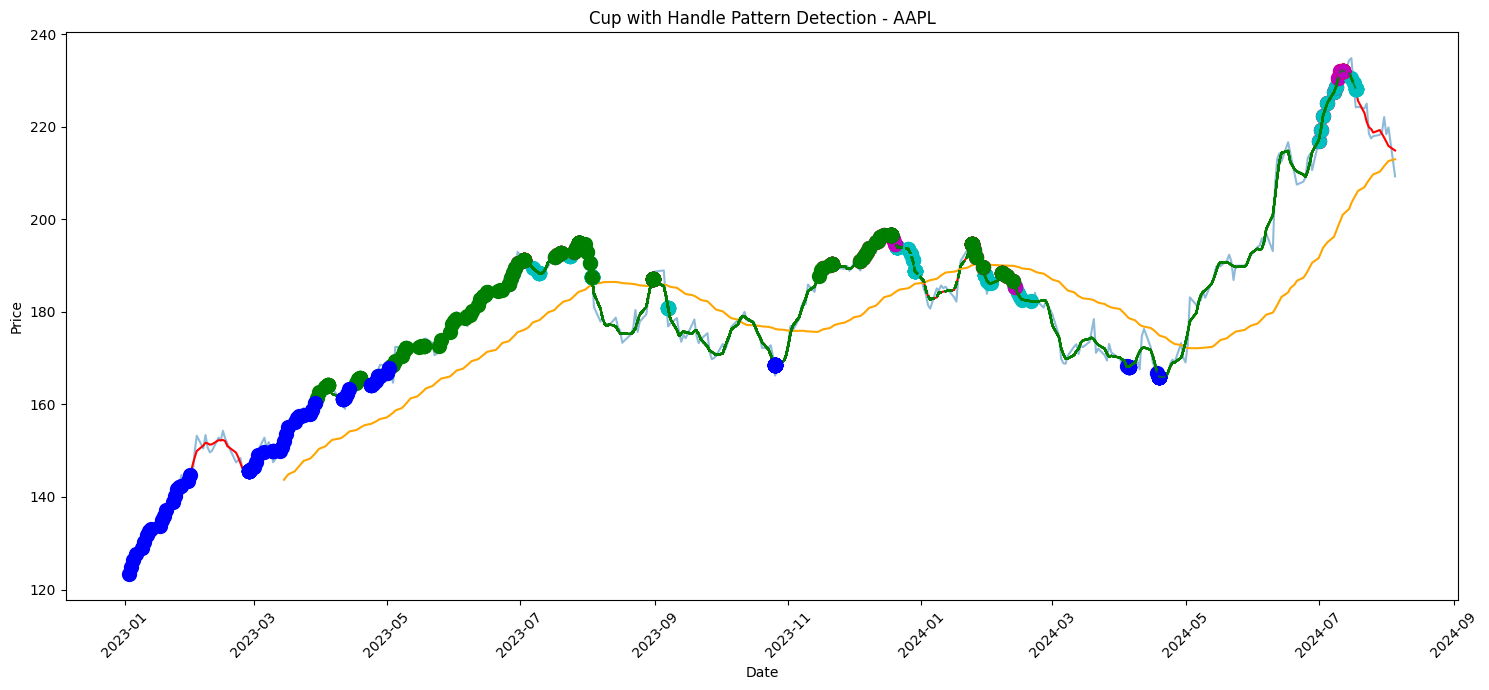

Cup with Handle pattern detected:
  Cup start: 2023-03-29 00:00:00-04:00
  Cup bottom: 2023-01-03 00:00:00-05:00
  Cup end: 2023-06-26 00:00:00-04:00
  Handle start: 2023-06-26 00:00:00-04:00
  Handle bottom: 2023-06-26 00:00:00-04:00

Cup with Handle pattern detected:
  Cup start: 2023-03-30 00:00:00-04:00
  Cup bottom: 2023-01-04 00:00:00-05:00
  Cup end: 2023-06-27 00:00:00-04:00
  Handle start: 2023-06-27 00:00:00-04:00
  Handle bottom: 2023-06-27 00:00:00-04:00

Cup with Handle pattern detected:
  Cup start: 2023-03-31 00:00:00-04:00
  Cup bottom: 2023-01-05 00:00:00-05:00
  Cup end: 2023-06-28 00:00:00-04:00
  Handle start: 2023-06-28 00:00:00-04:00
  Handle bottom: 2023-06-28 00:00:00-04:00

Cup with Handle pattern detected:
  Cup start: 2023-04-03 00:00:00-04:00
  Cup bottom: 2023-01-06 00:00:00-05:00
  Cup end: 2023-06-29 00:00:00-04:00
  Handle start: 2023-06-29 00:00:00-04:00
  Handle bottom: 2023-06-29 00:00:00-04:00

Cup with Handle pattern detected:
  Cup start: 2023-04-0

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import yfinance as yf

def download_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    return df.reset_index()

def preprocess_data(data, window_length=11, polyorder=2):
    smooth_close = savgol_filter(data['Close'], window_length, polyorder)
    data['MA50'] = data['Close'].rolling(window=50).mean()
    return smooth_close

def detect_cup_with_handle(data, smooth_close, window_size=60, cup_depth_threshold=0.1, handle_depth_threshold=0.05, handle_length_range=(5, 30)):
    patterns = []
    for i in range(window_size, len(data) - window_size):
        # Cup detection
        cup_start = i - window_size + np.argmax(smooth_close[i-window_size:i])
        cup_bottom = i - window_size + np.argmin(smooth_close[i-window_size:i+window_size])
        cup_end = i + np.argmax(smooth_close[i:i+window_size])
        
        cup_depth = smooth_close[cup_start] - smooth_close[cup_bottom]
        if cup_depth > cup_depth_threshold * smooth_close[cup_start]:
            # Handle detection
            for j in range(handle_length_range[0], min(handle_length_range[1], len(smooth_close) - cup_end)):
                handle_start = cup_end
                handle_bottom = cup_end + np.argmin(smooth_close[cup_end:cup_end+j])
                handle_depth = smooth_close[cup_end] - smooth_close[handle_bottom]
                
                if handle_depth < handle_depth_threshold * smooth_close[cup_end]:
                    if data['MA50'].iloc[handle_bottom] > data['MA50'].iloc[cup_start]:
                        patterns.append((cup_start, cup_bottom, cup_end, handle_start, handle_bottom))
                        break
    return patterns

def plot_results(data, smooth_close, patterns):
    plt.figure(figsize=(15, 7))
    plt.plot(data['Date'], data['Close'], label='Original Close Price', alpha=0.5)
    plt.plot(data['Date'], smooth_close, label='Smoothed Close Price', color='red')
    plt.plot(data['Date'], data['MA50'], label='50-day Moving Average', color='orange')
    
    colors = ['go', 'bo', 'ro', 'mo', 'co']
    labels = ['Cup Start', 'Cup Bottom', 'Cup End', 'Handle Start', 'Handle Bottom']
    
    for pattern in patterns:
        for i, point in enumerate(pattern):
            plt.plot(data['Date'][point], smooth_close[point], colors[i], markersize=10, label=labels[i] if i == 0 else "")
        
        # 패턴을 연결하는 선
        plt.plot(data['Date'][pattern[0]:pattern[-1]+1], smooth_close[pattern[0]:pattern[-1]+1], 'g--', alpha=0.7)
    
    plt.title(f'Cup with Handle Pattern Detection - {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    #plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 주식 데이터 다운로드 및 처리
ticker = "AAPL"  # Apple Inc.
start_date = "2023-01-01"
end_date = "2024-08-06"
df = download_stock_data(ticker, start_date, end_date)

# 데이터 전처리
smooth_close = preprocess_data(df)

# 패턴 탐지
patterns = detect_cup_with_handle(df, smooth_close, window_size=60, cup_depth_threshold=0.08, handle_depth_threshold=0.04)

# 결과 시각화
plot_results(df, smooth_close, patterns)

# 탐지된 패턴 정보 출력
for pattern in patterns:
    cup_start, cup_bottom, cup_end, handle_start, handle_bottom = pattern
    print(f"Cup with Handle pattern detected:")
    print(f"  Cup start: {df['Date'][cup_start]}")
    print(f"  Cup bottom: {df['Date'][cup_bottom]}")
    print(f"  Cup end: {df['Date'][cup_end]}")
    print(f"  Handle start: {df['Date'][handle_start]}")
    print(f"  Handle bottom: {df['Date'][handle_bottom]}")
    print()